## Importing essential Python Packages

In [2]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook
# %matplotlib inline
# %matplotlib widget
# %matplotlib ipympl

`sbfTools` hold all the auxiliary functions we use in this notebook.
Make sure that `sbfTools.py` is in located in the same folder as this notebook.

In [3]:
# make sure 
from sbfTools import *

## `get_RMS` 

Defining the `rms` of the flux deviations from the `r^1/4` profile, extrapolated in the outer regions of the target galaxy

In [4]:
def get_RMS(obj, r0, r1, nr, sky_factor):
    '''
    
    Returns:
        - rms: the rms of deviations
        - n_cross: number of ellipses crossing each other
    
    '''
    
    sky = int(sky_factor*obj.sky_med)
    n_cross = 0
    
    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=1, model_mask=0) != 'OK':
        n_cross+=1
        
    model = 0 
    n_cross += Xellipses(obj.list_ellipses(model=0))
    root = obj.objRoot
    suffix = '.%03d'%model

    ellipseFile = root+'/elliprof'+suffix
    df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
    df = df.apply(pd.to_numeric, errors='coerce')
    x = df.Rmaj**0.25
    y = 2.5*np.log10(df.I0)

    maxX = np.max(x)
    minX = np.min(x)
    dx = maxX-minX
    x1 = 0.60*dx+minX
    x2 = maxX-0.20*dx
    x3 = maxX-0.10*dx
    x0 = x[((x<x2) & (x>x1))]
    y0 = y[((x<x2) & (x>x1))]

    m, b = np.polyfit(x0, y0, 1)

    x_data = x[((x>=x3))]
    y_data = y[((x>=x3))]
    y_model = m*x_data+b

    rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
    return rms, n_cross


def get_f(obj, r0, r1, nr):
    '''
    
    
    Returns:
        - func: a function that gets the sky_factor and returns the rms of deviations
        This function in its heart uses function `get_RMS` 
    
    '''
    
    def func(sky_factor):

        rms, n_cross = get_RMS(obj, r0, r1, nr, sky_factor)

        sig = rms 

        if sig>10 or np.isnan(sig) or n_cross>0:
            sig = 10

        return -sig
    
    return func

In [5]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [6]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'

In [7]:
# obj = ellOBJ("n0679")
# obj = ellOBJ("u12517")
# obj = ellOBJ("n0439")


# obj = ellOBJ("n3308", inFolder=inFolder)

# obj = ellOBJ("n7265", inFolder=inFolder)

# obj = ellOBJ("n7426", inFolder=inFolder)

## very bright nearby object
# obj = ellOBJ("n6577", inFolder=inFolder)

# obj = ellOBJ("ic4727", inFolder=inFolder)

# obj = ellOBJ("ic0380", inFolder=inFolder)

## arms, shells
# obj = ellOBJ("n2418", inFolder=inFolder)

## doesn't exist
# obj = ellOBJ("e137008", inFolder=inFolder)

# obj = ellOBJ("u11990", inFolder=inFolder)

# bright nearby object
# obj = ellOBJ("n3268", inFolder=inFolder)

# obj = ellOBJ("n7274", inFolder=inFolder)

### Spiral arms, reject
# obj = ellOBJ("n6688", inFolder=inFolder)

## nuclear dust + companion
# obj = ellOBJ("n4825", inFolder=inFolder)

# obj = ellOBJ("n6768", inFolder=inFolder)

# obj = ellOBJ("n6223", inFolder=inFolder)


obj = ellOBJ("n7274", inFolder=inFolder)

NameError: name 'config' is not defined

In [ ]:
obj.sky_med, obj.x0, obj.y0

In [8]:
obj.x_max, obj.y_max

(1022, 1025)

In [9]:
r = min([obj.x0, obj.x_max-obj.x0, obj.y0, obj.y_max-obj.y0])

r, int(obj.r_max)

(457.174, 457)

<IPython.core.display.Javascript object>


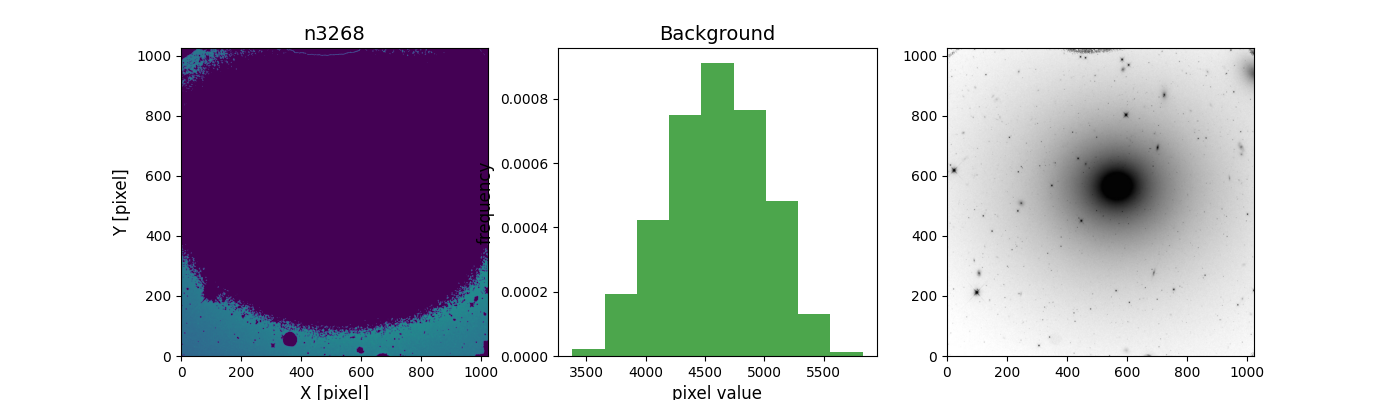

Back Median: 4605.46
Back Mean: 4597.94
Back Stdev: 406.64
fig. name:  Outputs_n3268//n3268_initial_back.png


In [10]:
obj.backSextract(thresh=0.03)
ax1, ax2, ax3 = obj.plot_background()

pngName = obj.objRoot+'/'+obj.name+'_initial_back.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

<IPython.core.display.Javascript object>


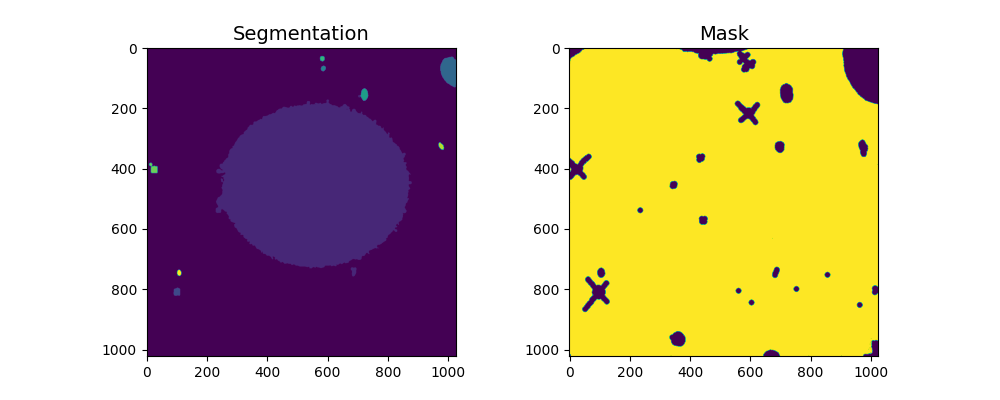

fig. name:  Outputs_n3268//n3268_initial_mask.png


In [11]:
ax1, ax2 = obj.naive_Sextract(minArea=200, thresh=3, mask=0, smooth=5)
ax1.set_title("Segmentation", fontsize=14)

obj.addMasks(maskList=[0], mask=1)

## improting Dmask and add it to the initial mask we find using 
## a crude SExtractor run
Dmask =  obj.inFolder+'{}/{}j.dmask'.format(obj.name, obj.name)
if os.path.exists(Dmask):
    obj.inputMaks(Dmask, mask=0)
    obj.addMasks(maskList=[0,1], mask=1)
else:
    print(Dmask+" doesn't exist.")

im, h = obj.maskOpen(mask=1)
ax2.imshow(np.flipud(im))
ax2.set_title("Mask", fontsize=14)

pngName = obj.objRoot+'/'+obj.name+'_initial_mask.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=r1/k`
- `options`: Any other that `elliprof` accepts. 

<IPython.core.display.Javascript object>


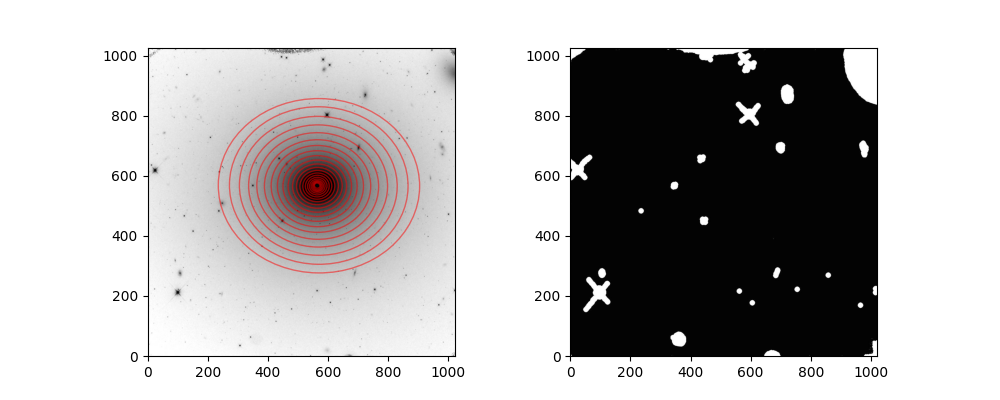

N_cross: 0
r0: 7
r1: 335
nr: 22
sky: 4144
fig. name:  Outputs_n3268//n3268_basic_model.png
CPU times: user 1.11 s, sys: 454 ms, total: 1.57 s
Wall time: 1.43 s


In [12]:
%%time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))


r0 = 7              # pixel
c_kron = 3     # Kron radius factor
k = 15 
sky_factor = 0.9    # always less than one

r1 = obj.outerR(c_kron)
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

## input mask. Usually mask = 1 or any value chosen for the initial mask from the previous cell
## since we have not specify the model number, the generated model takes a value of `0`
msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="", mask=1)

## Calculating the number of crossing ellipses, the generated model = 0, from previous linen_cross = Xellipses(obj.list_ellipses(model=0))
obj.tv(options="log", ax=ax1)
obj.plot_ellipse(model=0, ax=ax1, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

n_cross = Xellipses(obj.list_ellipses(model=0))

print("N_cross: %d"%n_cross)   # No. of crossing ellipses
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

obj.tv_mask(mask=1, ax=ax2)

pngName = obj.objRoot+'/'+obj.name+'_basic_model.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

## Second round of elliprof

Here, we use the primary model that we generated in the previous cell to cover the masked regions.
Then we run SExtractor for additional mask. The residuals of model=0 is used to create another mask. The initial mask can be further augmented with the mask we generate here.

- `model=0`: initial profile model from the previous cell. The masked regions are replaced by this model
- `model_mask`: the model that is used to patch the masked regions

**Top**
- Left: Red ellipse displays the galaxy border defined by Kron radius

In [13]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# text = widgets.Text(
#        value='My Text',
#        description='Title', )

# calendar = widgets.DatePicker(
#            description='Select Date')

slider_inner = widgets.FloatSlider(value=9, min=3, max=15, step=1, description='r0 (pixels)')
slider_kron = widgets.FloatSlider(value=2.5, min=1, max=5, step=0.25, description='Kron_factor')
slider_sky = widgets.FloatSlider(value=0.90, min=0.1, max=1.2, step=0.05, description='sky_factor')
slider_nEll = widgets.FloatSlider(value=15, min=5, max=50, step=1, description='k')

elliprof_options = widgets.Dropdown(
       options=['COS3X=0', 'COS3X=1', 'COS3X=2', 'COS4X=1', 'COS4X=2', 'COS3X=-1', 'COS3X=-2'],
       value='COS3X=0',
       description='Mode:')

# checkbox = widgets.Checkbox(
#            description='Check to invert',)
checkbox = widgets.Checkbox(description='Combine Mask', value = False)

box1 = widgets.VBox([slider_inner, slider_kron, slider_sky, slider_nEll])
box2 = widgets.VBox([elliprof_options])

widgets.HBox([box1, box2])





Outputs_n3268/obj.pro
sex Outputs_n3268//tmp -c wfc3j.inpar -CHECKIMAGE_NAME Outputs_n3268//objCheck.000.segment -CATALOG_NAME  Outputs_n3268//objCatal.000 -DETECT_MINAREA 300 -DETECT_THRESH 3 -ANALYSIS_THRESH 3 -CHECKIMAGE_TYPE SEGMENTATION  -WEIGHT_IMAGE  Outputs_n3268//model.000 -WEIGHT_TYPE  MAP_VAR
Outputs_n3268//objCheck.000.segment Outputs_n3268//objCheck.000 Outputs_n3268//mask.002


<IPython.core.display.Javascript object>


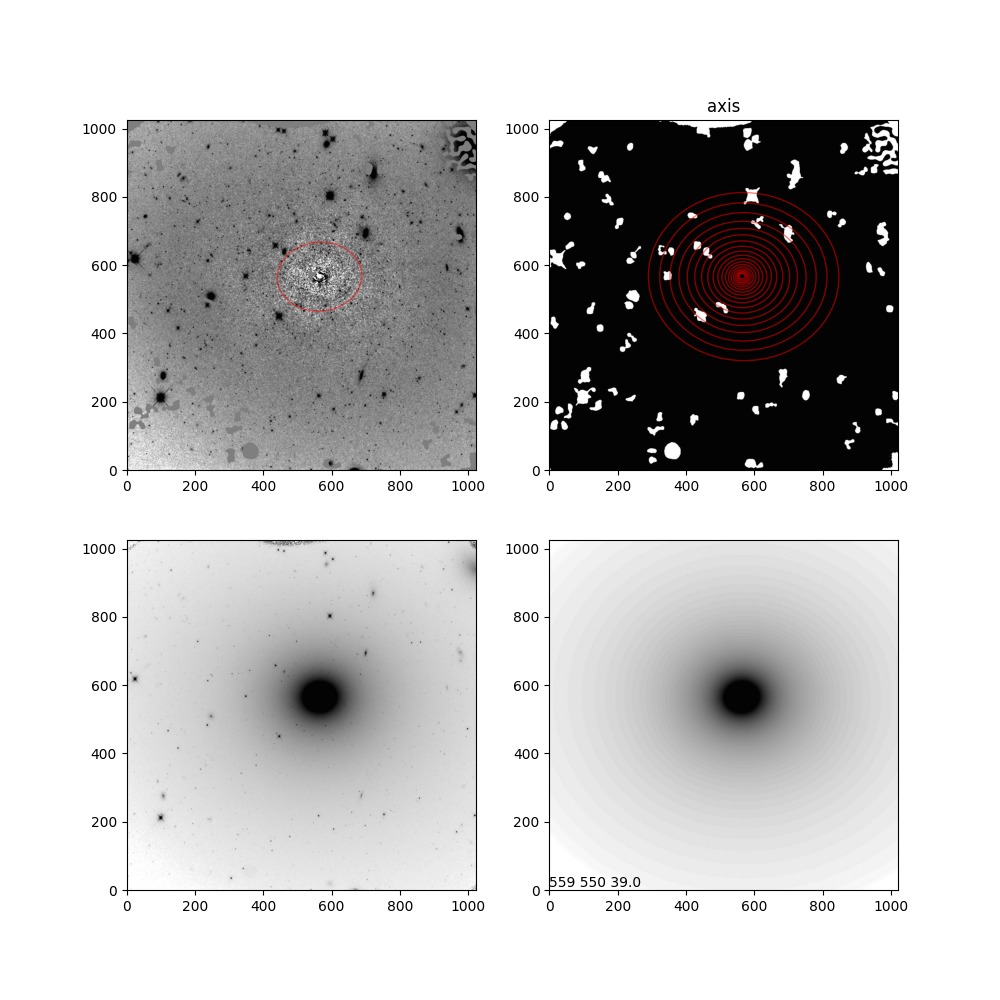

fig. name:  Outputs_n3268//n3268_initial_model.png


7

In [30]:
r0 = slider_inner.value          # pixels
c_kron = slider_kron.value # *kron_radius
r1 = obj.outerR(c_kron)    # pixels
k = slider_nEll.value
nr = int(np.round(r1/k))
sky_factor = slider_sky.value    # always less than one
   
options = elliprof_options.value
# options = ''
    
## using mask=1  --> primary mask
## generate model = 0   
## uses model_mask for the masked regions
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=10, mask=1, model_mask=0, options=options)

# using residuals of model 0 --> mask 2
obj.objSExtract(model=0, smooth=5, minArea=300, thresh=3, mask=2, renuc=1) 

# plotting model 0
fig, ax = plt.subplots(2, 2, figsize=(10,10))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
Ell = ((obj.x0, obj.y0), 1.*obj.a, 1.*obj.b, obj.angle)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
ax[0][0].add_patch(e)

obj.tv_mask(mask=2, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')




obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')


pngName = obj.objRoot+'/'+obj.name+'_initial_model.png'
plt.savefig(pngName)
print("fig. name: ", pngName)


resid = True

text=ax[1][1].text(0,0, "ehsan", va="bottom", ha="left") 
def onclick(event):
        global resid
        tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        text.set_text(tx)
        if event.inaxes == ax[0,1]:
            event.inaxes.set_title("axis")
            root = obj.objRoot
            segment = root+'/objCheck.000.segment'
            objName = root+'/objCheck.000'
            maskName = root+'/mask.002'
            
            imarray, header = imOpen(segment)
            i = int(event.xdata)
            j = int(event.ydata)
            
            n = imarray[j,i]
            text.set_text(str(i)+' '+str(j)+' '+str(n))
            imarray[(imarray==n)] = 0 
            fits.writeto(segment, np.float32(imarray), header, overwrite=True)
            seg2mask(segment, objName)
            ## Monsta script
            script = """
            rd 1 """+objName+"""
            rd 5 './common.mask'
            mi 1 5
            wd 1 """+maskName+""" bitmap
            tv 1 JPEG="""+maskName+""".jpg
            q

            """       
            obj.run_monsta(script, root+'monsta.pro', root+'monsta.log')
#             obj.tv_model(model=0, ax=ax[0,1], options='sqrt')
            obj.tv_mask(mask=2, ax = ax[0][1])
            draw()
            
        if event.inaxes == ax[0,0]:
            event.inaxes.set_title(resid)
            if resid:
                obj.tv(ax = ax[0][0], options='sqrt')
                resid = False
            else:
                obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
                resid = True
            draw()
            

fig.canvas.callbacks.connect('button_press_event', onclick)


In [31]:
checkbox

Checkbox(value=True, description='Combine Mask')

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [32]:
# combining mask1 and mask2 ----> mask1
if checkbox.value:
    obj.addMasks(maskList=[1,2], mask=1)

<IPython.core.display.Javascript object>


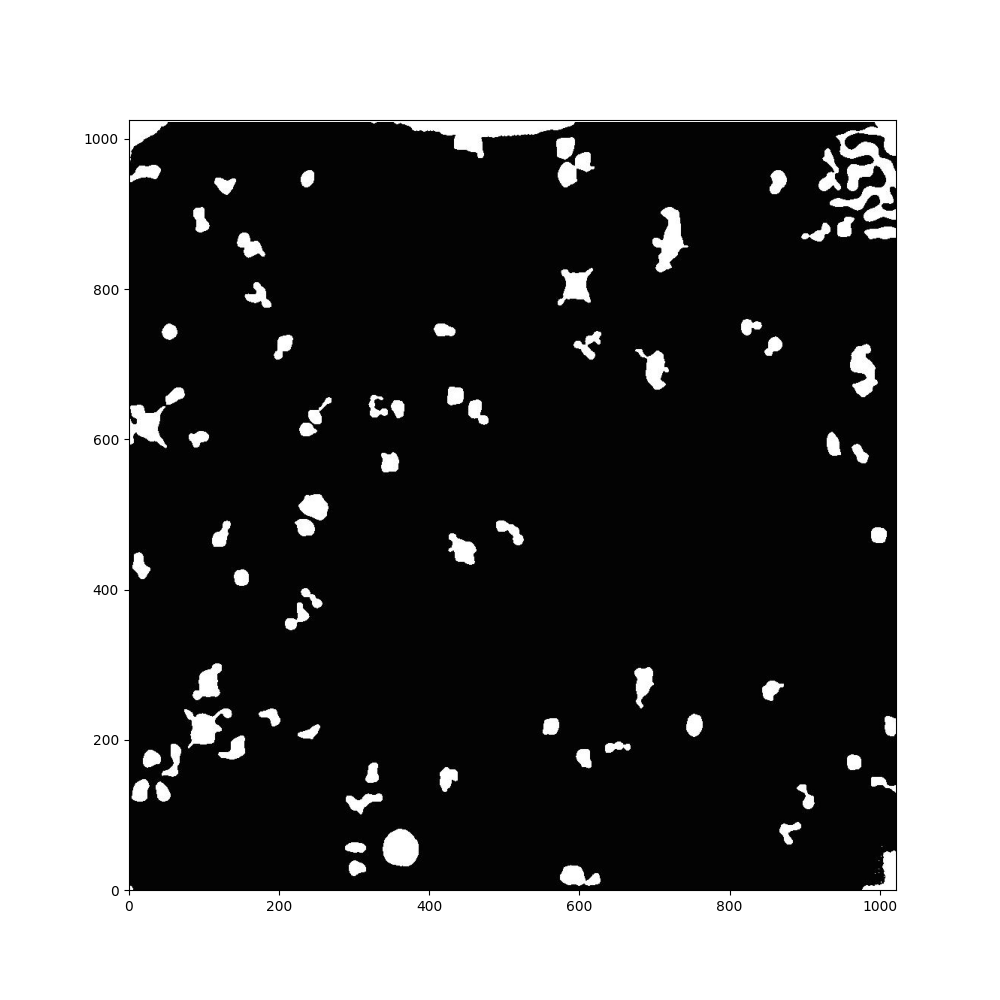

In [36]:
obj.tv_mask(mask=2)

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [37]:
First = True

for i in range(25):
    
    sky = sky_factor*obj.sky_med

    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=1, model_mask=0) != 'OK':
        print("Err")
        break


    resid_name = obj.objRoot+"resid.000"
    back_mask = obj.objRoot+"back_mask.fits"

    imarray, header = imOpen(resid_name)
    mskarray, header = imOpen(back_mask)

    masked_image = imarray*mskarray


    a = masked_image
    a = a[(a!=0)]
    std = np.std(a)
    mean = np.mean(a)

    a = a[((a>mean-3.*std)&(a<mean+3.*std))]

    median = np.median(a)
    mean = np.mean(a)
    std = np.std(a)

    sky_factor = median/obj.sky_med + sky_factor
    
    abs_median = np.abs(median)
    if First:
        min_absmed = abs_median
        min_factor = sky_factor
        min_med = median 
        First = False
    elif abs_median<min_absmed:
        min_absmed = abs_median
        min_factor = sky_factor
        min_med = median       
    

    if i%5==0:
        print("%02d median:%.2f factor:%.4f"%(i, median, sky_factor))

print("Optimum --- median:%.2f factor:%.4f"%(min_med, min_factor))
sky_factor = min_factor

00 median:-523.91 factor:0.7862
05 median:-0.36 factor:0.6982
10 median:38.78 factor:0.7083
15 median:-17.46 factor:0.6969
20 median:15.48 factor:0.7053
Optimum --- median:-0.36 factor:0.6982


## An alternative to tune the background level

Here, we fit an `r^1/4` profile, and optimize the background factor to minimize the `rms` of deviations from the profile in the outer regions.

This method doesn't necessarily work for all galaxies. There are smaller galaxies that do not obey the `r^1/4` law. For such instances, the other method might be quite adequate.

A Bayesian optimization technique is leveraged to find the optimum sky factor here. The boundaries of the search space is set to be `(0.65, 1.05)`, however this can be altered as required.


In [19]:
%%time

## make it `True` if you ever want to use this routine
if False:
    from bayes_opt import BayesianOptimization
    ### https://github.com/fmfn/BayesianOptimization

    # Bounded region of parameter space
    pbounds = {'sky_factor': (0.65, 1.05)}

    optimizer = BayesianOptimization(
        f=get_f(obj, r0, r1, nr),
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize(
        init_points=3,
        n_iter=15,
    )

    sky_factor = optimizer.max['params']['sky_factor']

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.8 µs


## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

<IPython.core.display.Javascript object>


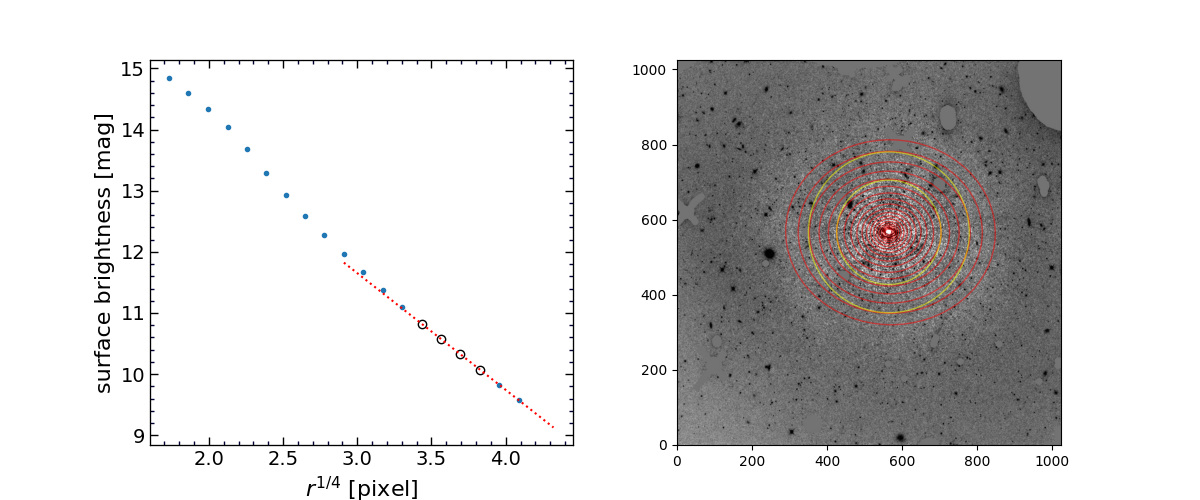

No. of crossing ellipses: 0
fig. name:  Outputs_n3268//n3268_light_profile.png


In [20]:
sky = int(sky_factor*obj.sky_med)

# using final mask = 1 --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=10, mask=1, model_mask=0, options=options)

model = 0
root = obj.objRoot
suffix = '.%03d'%model

ellipseFile = root+'/elliprof'+suffix
df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
df = df.apply(pd.to_numeric, errors='coerce')

# fig, ax = plt.subplots(1,1, figsize=(7,6))
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,5))

x = df.Rmaj**0.25
y = 2.5*np.log10(df.I0)
ax.plot(x, y, '.')

ax.set_xlabel(r"$r^{1/4}$"+" [pixel]", fontsize=16)
ax.set_ylabel(r"surface brightness"+" [mag]", fontsize=16)

maxX = np.max(x)
minX = np.min(x)
dx = maxX-minX
x1 = 0.70*dx+minX
x2 = maxX-0.10*dx
x0 = x[((x<x2) & (x>x1))]
y0 = y[((x<x2) & (x>x1))]
ax.plot(x0, y0, 'ko', mfc='white')

m, b = np.polyfit(x0, y0, 1)

xrange = np.linspace(x1-0.2*dx, maxX+0.1*dx, 100)
yrange = m*xrange+b

ax.plot(xrange, yrange, 'r:')
set_axes(ax, fontsize=14)

##################################################
obj.tv_resid(model=0, options='sqrt', ax=ax2)
obj.plot_ellipse(model=0, ax=ax2, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
n_cross = Xellipses(obj.list_ellipses(model=0))
print("No. of crossing ellipses: %d"%n_cross)


## center, Smajor, Smainor, angle
Ell = make_Ellipse((obj.x0, obj.y0), min(x0)**4, min(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)

Ell = make_Ellipse((obj.x0, obj.y0), max(x0)**4, max(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)


pngName = obj.objRoot+'/'+obj.name+'_light_profile.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: 15.78
Back Mean: 20.93
Back Stdev: 205.71


<IPython.core.display.Javascript object>


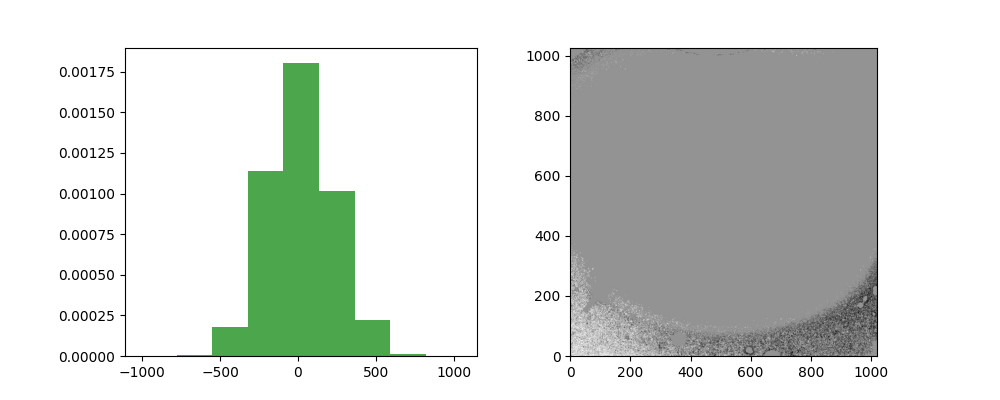

fig. name:  Outputs_n3268//n3268_updated_back.png


0.7101508830335109

In [21]:
resid_name = obj.objRoot+"resid.000"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
std = np.std(a)
mean = np.mean(a)

a = a[((a>mean-3.*std)&(a<mean+3.*std))]

median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.hist(a, bins=np.linspace(mean-5*std, mean+5*std, 10), density=True, color='g', alpha=0.7)
tv('./tmp.fits', ax=ax2, options="")

new_factor = median/obj.sky_med + sky_factor


pngName = obj.objRoot+'/'+obj.name+'_updated_back.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

new_factor

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [38]:
objDict = {}

objDict["index"] = 'value'
objDict["Name"] = obj.name
objDict["X_pixels"] = obj.x_max
objDict["Y_pixels"] = obj.y_max
objDict["R_max"] = obj.r_max
objDict["X0"] = obj.x0
objDict["Y0"] = obj.y0
objDict["a"] = obj.a
objDict["b"] = obj.b
objDict["sky_med"] = median
objDict["sky_avg"] = mean
objDict["sky_std"] = std
objDict["r0"] = r0
objDict["r1"] = r1
objDict["nr"] = nr
objDict["k"] = k
objDict["c_kron"] = c_kron
objDict["options"] = options
objDict["sky_factor"] = sky_factor
objDict["sky"] = sky
objDict["initial_sky_med"] = obj.sky_med
objDict["initial_sky_avg"] = obj.sky_ave
objDict["initial_sky_std"] = obj.sky_std

objDict["obj_root"] = obj.objRoot

objDict["resid_name"] = obj.objRoot+"resid.000"
objDict["model_name"] = obj.objRoot+"model.000"
objDict["back_mask"] = obj.objRoot+"back_mask.fits"
objDict["ellipseFile"] = root+'elliprof'+suffix

#######################################################################

df = pd.DataFrame.from_dict(objDict, orient='index', columns=['value'])
df['description'] = ''

#######################################################################
df.at["index", "description"] =  'description'

df.at["Name", "description"] =  'Object Name'
df.at["X_pixels", "description"] =  'X-dimension of image [pixel]'
df.at["Y_pixels", "description"] =  'Y-dimension of image [pixel]'
df.at["R_max", "description"] =  'maximum horizontal/vertical distance from center to the image border [pixel]'
df.at["X0", "description"] =  'Object Center X0 [pixel]'
df.at["Y0", "description"] =  'Object Center Y0 [pixel]'
df.at["a", "description"] =  'semi-major axis [pixel]'
df.at["b", "description"] =  'semi-minor axis [pixel]'
df.at["sky_med", "description"] =  'median sky background after model subtraction'
df.at["sky_avg", "description"] =  'mean sky background after model subtraction'
df.at["sky_std", "description"] =  '1-sigma standard deviation of the sky background after model subtraction'
df.at["r0", "description"] =  'elliprof: inner fit radius'
df.at["r1", "description"] =  'elliprof: outer fit radius'
df.at["nr", "description"] =  'elliprof: number of fitted radii '
df.at["k", "description"] =  'nr=[r1/k]'
df.at["c_kron", "description"] =  'Kron radius factor'
df.at["options", "description"] =  'elliprof: options'
df.at["sky_factor", "description"] =  'sky factor'
df.at["sky", "description"] =  'sky level = sky_factor*initial_sky_median'
df.at["initial_sky_med", "description"] =  'initial sky median'
df.at["initial_sky_avg", "description"] =  'initial sky mean'
df.at["initial_sky_std", "description"] =  'initial sky standard deviation'

df.at["obj_root", "description"] =  'name of the outputs folder'

df.at["resid_name", "description"] =  'residual image [fits]'
df.at["model_name", "description"] =   'model image [fits]'
df.at["back_mask", "description"] =   'background mask [fits]'
df.at["ellipseFile", "description"] =   'ellipse file [text]'

#######################################################################

df = df.reset_index()
logFile = obj.objRoot+obj.name+"_model_log.csv"
np.savetxt(logFile, df.values, fmt='%20s , %40s , %80s')
print("Log File: ", logFile)
df


Log File:  Outputs_n3268/n3268_model_log.csv


,index,value,description
0,index,value,description
1,Name,n3268,Object Name
2,X_pixels,1022,X-dimension of image [pixel]
3,Y_pixels,1025,Y-dimension of image [pixel]
4,R_max,457,maximum horizontal/vertical distance from cent...
5,X0,564.826,Object Center X0 [pixel]
6,Y0,566.165,Object Center Y0 [pixel]
7,a,123.8325,semi-major axis [pixel]
8,b,100.9305,semi-minor axis [pixel]
9,sky_med,-33.196594,median sky background after model subtraction


In [23]:
df.at["Name", "description"] = 'test'

df

,index,value,description
0,index,value,description
1,Name,n3268,Object Name
2,X_pixels,1022,X-dimension of image [pixel]
3,Y_pixels,1025,Y-dimension of image [pixel]
4,R_max,457,maximum horizontal/vertical distance from cent...
5,X0,564.826,Object Center X0 [pixel]
6,Y0,566.165,Object Center Y0 [pixel]
7,a,123.8325,semi-major axis [pixel]
8,b,100.9305,semi-minor axis [pixel]
9,sky_med,15.780151,median sky background after model subtraction


# Using the hybrid SExtractor + Dophot to measure the GCLF

## 1. Do the first run with SExtractor as normal:

- Make sure the intial mask removes any brighter galaxies. It’s only the faint extended objects we want to be fitting.
- Run SExtractor on the residual image (see below for procedure).
- Run `mkincat_j_3.py` --> `n1234se.lknj`
- Run likenew on `n1234se.lknj` --> `n1234sej.lkn6` and `n1234sej.ptm6`
- Edit `n1234sej.ptm6` to clear any residuals --> `n12349sej.ptm6b` bitmap

In [24]:
## mask=0 is the common mask + dmask

obj.objSExtract(model=0, smooth=None, minArea=5, thresh=1.2, mask=0, renuc=1) 

catalName = obj.objRoot+'/objCatal.000'

Outputs_n3268/obj.pro
sex Outputs_n3268//resid.000 -c wfc3j.inpar -CHECKIMAGE_NAME Outputs_n3268//objCheck.000.segment -CATALOG_NAME  Outputs_n3268//objCatal.000 -DETECT_MINAREA 5 -DETECT_THRESH 1.2 -ANALYSIS_THRESH 1.2 -CHECKIMAGE_TYPE SEGMENTATION  -WEIGHT_IMAGE  Outputs_n3268//model.000 -WEIGHT_TYPE  MAP_VAR
Outputs_n3268//objCheck.000.segment Outputs_n3268//objCheck.000 Outputs_n3268//mask.000


In [25]:
def getColName(catalName):
        with open(catalName, 'r') as f:

            lines = f.readlines()

        cols = {}
        i = 0 
        while lines[i].split()[0]=="#":
            j = int(lines[i].split()[1])
            name = lines[i].split()[2]
            
            n = 1
            cols[i] = [j, name, n]
            
            if i>0:
                n = cols[i][0]-cols[i-1][0]
                cols[i-1][2] = n

#             col_names.append()   
            
            i+=1
        
        col_names = []
        n_head = i
        for m in range(i):
            s = cols[m][2]
            name = cols[m][1]
            if s==1:
                col_names.append(name)
            else:
                for p in range(s):
                    col_names.append(name+'_'+str(p+1))
                            
        return n_head, col_names
    

n_head, col_names = getColName(catalName)

print(len(col_names))
print(col_names)

catalDF = pd.read_csv(catalName, delimiter=r"\s+", skiprows=n_head, 
                         header = None, names = col_names)

catalDF.head()

32
['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'MAG_AUTO', 'MAGERR_AUTO', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'FWHM_IMAGE', 'ELLIPTICITY', 'FLAGS', 'CLASS_STAR', 'CXX_IMAGE', 'CYY_IMAGE', 'CXY_IMAGE', 'KRON_RADIUS', 'MAG_APER_1', 'MAG_APER_2', 'MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAGERR_APER_1', 'MAGERR_APER_2', 'MAGERR_APER_3', 'MAGERR_APER_4', 'MAGERR_APER_5', 'MAG_ISO', 'MAGERR_ISO', 'MAG_ISOCOR', 'MAGERR_ISOCOR']


,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAGERR_AUTO,A_IMAGE,B_IMAGE,THETA_IMAGE,...,MAG_APER_5,MAGERR_APER_1,MAGERR_APER_2,MAGERR_APER_3,MAGERR_APER_4,MAGERR_APER_5,MAG_ISO,MAGERR_ISO,MAG_ISOCOR,MAGERR_ISOCOR
0,1,306.171,35.921,157.522132,-35.337680,19.4205,0.0016,2.464,2.383,59.8,...,19.4606,0.0009,0.0009,0.0009,0.0010,0.0012,19.3989,0.0019,19.3908,0.0019
1,2,933.875,29.203,157.495730,-35.347438,23.2915,0.0555,2.942,1.987,83.7,...,23.5467,0.0526,0.0470,0.0448,0.0380,0.0396,23.4497,0.0396,23.1863,0.0449
2,3,596.113,19.555,157.510161,-35.342596,20.6745,0.0112,6.143,4.998,-19.5,...,21.8921,0.0158,0.0143,0.0138,0.0104,0.0092,20.7492,0.0088,20.6468,0.0097
3,4,662.372,22.240,157.507317,-35.343522,24.0618,0.1266,1.597,1.236,50.7,...,24.5498,0.1358,0.1196,0.1144,0.1014,0.1032,24.9066,0.0915,24.4305,0.1011
4,5,731.907,4.905,157.504672,-35.345113,22.0909,0.0243,5.197,2.461,-9.4,...,22.5357,0.0276,0.0196,0.0183,0.0149,0.0160,22.1100,0.0169,22.0337,0.0173


In [26]:
len(catalDF)

974

In [39]:
header = '''
# Region file format: DS9 version 4.1
image
'''

#### ---> Outputs_n0439/n0439_se.lknj

filter = 'j'
gal = 0 
gc = 0


gxy = obj.name

SXfile = obj.objRoot+'/objCatal.000'

sxtr = open(SXfile, 'r')
#    test = open(gxy + filter + '.se.test.out', 'w')
alk = open(obj.objRoot+gxy+'_se.lkn'+filter, 'w')

Xctr = obj.x0
Yctr = obj.y0
# I already put m1star in the sextractor .inpar files
#    m1zpt = gxys[gxy]['m1star814']
m1zpt = 0.0

#    test.write('#  0  1         2         3     4      5          6       7       8       9      10      11       12\n')
#    test.write('#  N  magaut   +/-       m4    +/-   maut_cor   m4cor   star     m5     +/-    m5cor  aut_cor  isoerr\n')
alk.write('%4s %8.2f %7.2f %8.2f  0 %9.5f %9.5f %9.5f  %5s %7.4f %5s %8.4f %6.4f\n' \
         %('0', Xctr, Yctr, 0, 0,0,0, '0.00', 0, '0', 0, 0))

xpos_lst = []
ypos_lst = []

id = catalDF.NUMBER
xpos = catalDF.X_IMAGE - 0.5
ypos = catalDF.Y_IMAGE - 0.5
radius = ((Xctr-xpos)**2 + (Yctr-ypos)**2)**0.5 
magauto = catalDF.MAG_AUTO + m1zpt
magautoerr = catalDF.MAGERR_AUTO
AA = catalDF.A_IMAGE       # A_IMAGE  
BB = catalDF.B_IMAGE       # B_IMAGE 
fwhm = catalDF.FWHM_IMAGE
star = catalDF.CLASS_STAR  # Class_star S/G (1=galaxy, 0=star)
pa = catalDF.THETA_IMAGE

cxx = catalDF.CXX_IMAGE
cyy = catalDF.CYY_IMAGE
cxy = catalDF.CXY_IMAGE
kron = catalDF.KRON_RADIUS
magiso = catalDF.MAG_ISO + m1zpt
magisoerr = catalDF.MAGERR_ISO

m4 = catalDF.MAG_APER_4 + m1zpt
m5 = catalDF.MAG_APER_5 + m1zpt
m4err = catalDF.MAGERR_APER_4
m5err = catalDF.MAGERR_APER_5

with open('ds9.reg', 'w') as f:
    f.write(header)
    for i in range(len(catalDF)):       

    #            aut_cor = max(0.05, 0.1 + 0.01*(magauto-19.5))
    # We haven't determined a correction for auto mags for WFC3/IR yet
            aut_cor = 0

    # From Cho et al. 2016
            magautocor = magauto[i] - aut_cor
            m4cor = m4[i] - 0.259  # aperture correction particular filter F110W, particular instrument WFC3-IR
            m5cor = m5[i] - 0.259
            
            isStar = False
            if star[i] >= 0.7 and m5err[i] < 50. and magautoerr[i] < 50. :
                mtot = m5cor
                mtoterr = m5err[i]
                gc = gc + 1
                isStar = True
            else:
                mtot = magautocor
                mtoterr = magautoerr[i]
                gal = gal + 1
               
            merr = min(mtoterr, magisoerr[i])

            # already extinction corrected
            # add check to make sure it's a reasonable & useful object:
            # changed merr>50 to merr>0.3 to produce a cleaner sample.
            # Ignore objects within 10 pix of the galaxy center.
            if merr>0.3 or radius[i]<10:
                continue
            # Add a check to remove the bad objects with FWHM=0 that SE sometimes finds 
            # These single pixel object might be bad pixels or cosmic rays
            # in masked areas of WFC3/IR data;
            # reduced fwhm limit to 20 pix to avoid huge residual "galaxies" (maybe only needed for Coma)
            if fwhm[i]<0.01 or fwhm[i]>10:
    #                gal = gal - 1
                continue
        
            if isStar:
                f.write("circle(%.4f, %.4f, 3) # color=red \n"%(xpos[i]+0.5,ypos[i]+0.5))
            else:
                f.write("ellipse(%.4f, %.4f, %.4f, %.4f, %.4f) # color=green \n"%(xpos[i]+0.5,ypos[i]+0.5,kron[i]*AA[i], kron[i]*BB[i], pa[i]))
                

            alk.write('%5s %8.2f %7.2f %8.2f  1 %9.5f %8.5f %9.5f  %5s %7.4f %5s %8.4f %6.4f %6.3f %6.4f\n' \
                         %(id[i], xpos[i], ypos[i], radius[i], cxx[i], cyy[i], cxy[i], kron[i], AA[i], id[i], mtot, mtoterr, star[i], merr))

            xpos_lst.append(xpos[i])
            ypos_lst.append(ypos[i])
            
        

sxtr.close()
print('read: ', SXfile)
#    test.close()
alk.close()
#    print('wrote '+gxy+filter+'.se.test.out')
print('wrote: ', obj.objRoot+gxy+'_se.lkn'+filter)
print('GCs: ',gc)
print('galaxies: ',gal)
gal=0
gc=0

read:  Outputs_n3268//objCatal.000
wrote:  Outputs_n3268/n3268_se.lknj
GCs:  650
galaxies:  324


In [28]:
xcmd("ds9 "+obj.objRoot+"/resid.000 &")


ds9 Outputs_n3268//resid.000 &


''

In [ ]:
def get_img(fits_file, ax=None, options=""):

    jpg_name = 'tv.jpg'

    ## Monsta script
    script = """
    rd 1 '"""+fits_file+"""'
    tv 1 """+options+""" JPEG="""+jpg_name+"""
    q

    """

    run_monsta(script, 'tv.pro', 'tv.log')
    
    xcmd("rm tv.pro & rm tv.log &", verbose=False)
    
    
    img = mpimg.imread(jpg_name)
    
    return img

In [ ]:
from bokeh.models.widgets import Panel, Tabs, TextInput
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

In [ ]:
len(xpos_lst)

In [ ]:
from bokeh.models import ColumnDataSource, Slider

tools_to_show = 'hover,pan,save,reset,wheel_zoom' #, crosshair'

TOOLTIPS = [
    ("(x,y)", "($x, $y)"),
]


model = 0 
root = obj.objRoot
suffix = '.%03d'%model
jpg_name = root+'/resid'+suffix+'.jpg'

print(jpg_name)

img = mpimg.imread(jpg_name)
x_max, y_max, _ = img.shape

# img = ascent()/256.0

rsd = figure(width=int(np.round(img.shape[0]/1.7)), height=int(np.round(img.shape[1]/1.7)), 
                 x_range=[0, img.shape[0]], y_range=[0, img.shape[1]], tools=tools_to_show, tooltips=TOOLTIPS)
rsd.image(image=[np.flipud(img[:,:,0])], x=[0], y=[0],
           dw=[img.shape[0]], dh=[img.shape[1]])

rsd.circle(xpos_lst, ypos_lst, size=10, color="red", alpha=0.9, fill_color=None)


img = get_img(inFolder+'/n0439/n0439j.fits', options='log')
x_max, y_max, _ = img.shape

img = img[::-1]

galaxy = figure(width=int(np.round(img.shape[0]/1.7)), height=int(np.round(img.shape[1]/1.7)), 
                 x_range=rsd.x_range, y_range=rsd.y_range, tools=tools_to_show, tooltips=TOOLTIPS)
galaxy.image(image=[img[:,:,0]], x=0, y=0,
           dw=img.shape[0], dh=img.shape[1], palette="Greys256")


galaxy.circle(xpos_lst, ypos_lst, size=10, color="red", alpha=0.9, fill_color=None)


# Create two panels, one for each conference
panel1 = Panel(child=rsd, title='residual')
panel2 = Panel(child=galaxy, title='galaxy')

# Assign the panels to Tabs
tabs = Tabs(tabs=[panel2, panel1])

# Show the tabbed layout
show(tabs)


# show(rsd)

In [ ]:
def getColName(catalName):
        with open(catalName, 'r') as f:

            lines = f.readlines()

        cols = {}
        i = 0 
        while lines[i].split()[0]=="#":
            j = int(lines[i].split()[1])
            name = lines[i].split()[2]
            
            n = 1
            cols[i] = [j, name, n]
            
            if i>0:
                n = cols[i][0]-cols[i-1][0]
                cols[i-1][2] = n

#             col_names.append()   
            
            i+=1
        
        col_names = []
        for m in range(i):
            s = cols[m][2]
            name = cols[m][1]
            if s==1:
                col_names.append(name)
            else:
                for p in range(s):
                    col_names.append(name+'_'+str(p+1))
                            
        return col_names
    
catalName = 'Outputs_n0439/catal.dat'
col_names = getColName(catalName)
df = pd.read_csv(catalName, delimiter=r"\s+", skiprows=len(col_names), 
                         header = None, names = col_names)

df.head()

In [ ]:
col_names

In [ ]:

im, h = obj.maskOpen(mask=1)


import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")


def onclick(event):
#     artist = event.artist
#     xmouse, ymouse = event.mouseevent.xdata, event.mouseevent.ydata
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
#     print(event.button, event.x, event.y, event.xdata, event.ydata)
    
# fig, ax = plt.subplots()

# tolerance = 10 # points
# ax.plot(range(10), 'ro-')
# ax.imshow(np.flipud(im), picker=tolerance)
fig.canvas.callbacks.connect('button_press_event', onclick)


plt.show()


In [ ]:
# %matplotlib widget

# some handy functions to use along widgets


In [ ]:
menu

In [ ]:
box = widgets.VBox([text, slider, menu, calendar, checkbox ])
box

In [ ]:
widgets.HBox([box, box])


In [ ]:
# defining a list with the contents of our windows
children = [box, box]
# initializing a tab
tab = widgets.Tab()
# setting the tab windows 
tab.children = children
# changing the title of the first and second window
tab.set_title(0, 'box')
tab.set_title(1, 'copy of box')
tab

In [ ]:
# current value of text, checkbox and calendar 
print('Widget text has value {}, of {}'.format(text.value, type(text.value)))
print('Widget checkbox has value {}, of {}'.format(checkbox.value, type(checkbox.value)))
print('Widget checkbox has value {}, of {}'.format(menu.value, type(menu.value)))
print('Widget checkbox has value {}, of {}'.format(slider.value, type(slider.value)))
print('Widget calendar has value {}, of {}'.format(calendar.value, type(calendar.value)))

In [ ]:
# We'll use the value of menu to display a plot and its title
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.plot([1,2,3], color = menu.value)
plt.title('A {} line'.format(menu.value))
plt.show()

In [ ]:
button = widgets.Button(description='My Button')
out = widgets.Output()
def on_button_clicked(_):
      # "linking function with output"
      with out:
          # what happens when we press the button
          clear_output()
          print('Something happens!')
# linking button and function together using a button's method
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])